# Classifying primary tumor with microRNA markers

### Raw data from TCGA is processed in R 
- `mirna_data_processing.R` 
- `raw_data.R`
- `nano_count.R`

### Some parameter tuning is computed on the UIUC nano cluster: 
- `nn_loop_miRNA.py`
- `nn_miRNA.py` 

Data structures from the cluster are saved using cPickle, and loaded into this jupyter notebook for further visualization and analysis. 

Files generated by R can be found under the `tumor-origin/mirna` folder

In [1]:
import tensorflow as tf
import numpy
import pandas as pd 
from tensorflow.keras import layers 
from tensorflow.keras.utils import to_categorical

from numpy import random

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import cPickle as pickle

data = pd.read_csv('mirna/raw.txt', sep='\t')
types = pd.read_csv('mirna/types-numeric.txt', sep='\t')
labels = pd.read_csv('mirna/types-labels.txt', sep='\t')


In [2]:
# train test split 
random.seed(69)
ii = numpy.random.rand(len(data)) < 0.7 

np_data = data.values
np_types = types.values
np_labels = labels.values

# # scaling data 
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# np_data_min_max = min_max_scaler.fit_transform(np_data)

# train = np_data_min_max[ii]
# test = np_data_min_max[~ii]

train = np_data[ii]
test = np_data[~ii]

# types = numbers assigned (0-16)
train_types = np_types[ii]
test_types = np_types[~ii]

# labels = string values assigned (then one-hot encoded later)
train_labels = np_labels[ii]
test_labels = np_labels[~ii] 

# ravel 
r_train_types = train_types.ravel()
r_test_types = test_types.ravel()

r_train_labels = train_labels.ravel()
r_test_labels = test_labels.ravel()

# One hot encoding of string labels for keras model 
encoded_train = to_categorical(r_train_types)
encoded_test = to_categorical(r_test_types)


## Baseline models 
- Random Forest 
- KNN
- SVM (computed but not used) 

In [3]:
# random forest baseline 

rfmodel = RandomForestClassifier(n_estimators=100)
rf = rfmodel.fit(train, r_train_labels)

rf_pred = rf.predict(test)

# Model Accuracy, how often is the classifier correct
print("Accuracy: ", metrics.accuracy_score(r_test_labels, rf_pred))
rf_cm = confusion_matrix(r_test_labels, rf_pred,)

y_true = pd.Series(r_test_labels)
rf_pred = pd.Series(rf_pred)

pd.crosstab(y_true, rf_pred, rownames=['True'], colnames=['Predicted'], margins=True)

('Accuracy: ', 0.9537037037037037)


Predicted,blca,brca,chol,coad,esca,hnsc,kich,kirc,lich,luad,ov,paad,prad,skcm,stad,thca,ucec,All
True,,,,,,,,,,,,,,,,,,
blca,128,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,132
brca,1,372,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,373
chol,0,2,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12
coad,0,2,0,152,0,0,0,0,0,0,0,0,0,0,0,0,0,154
esca,24,3,0,5,33,0,0,0,0,0,0,0,0,0,1,0,0,66
hnsc,1,1,0,0,0,154,0,0,0,0,0,0,0,0,0,0,1,157
kich,0,0,0,0,0,0,28,1,0,0,0,0,0,0,0,0,1,30
kirc,1,1,0,0,0,0,1,175,0,0,0,0,0,0,0,0,0,178
lich,0,0,0,0,1,0,0,0,118,0,0,0,0,1,0,0,0,120


In [4]:
# Random Forest Classification report 
print(classification_report(y_true, rf_pred))

print(accuracy_score(y_true, rf_pred, normalize=True, sample_weight=None))

              precision    recall  f1-score   support

        blca       0.82      0.97      0.89       132
        brca       0.93      1.00      0.96       373
        chol       1.00      0.83      0.91        12
        coad       0.92      0.99      0.95       154
        esca       0.97      0.50      0.66        66
        hnsc       0.98      0.98      0.98       157
        kich       0.97      0.93      0.95        30
        kirc       0.99      0.98      0.99       178
        lich       1.00      0.98      0.99       120
        luad       0.96      0.91      0.93       173
          ov       0.99      0.97      0.98       144
        paad       0.97      0.78      0.87        50
        prad       0.99      0.99      0.99       170
        skcm       0.99      1.00      1.00       123
        stad       0.94      0.90      0.92       146
        thca       0.99      0.99      0.99       169
        ucec       0.94      0.96      0.95       179

   micro avg       0.95   

In [5]:
def getClassAccuracy(rf_cm):
    for i in range (len(rf_cm)): 
        print("\n" + str(i) + ": " + cancers[i])

        # TP
        tp = rf_cm[i][i]
        print("TP: " + str(rf_cm[i][i]))

        # FP, columns...things that are classified as XXX cancer, but are not
        fp = 0
        for col in range(len(rf_cm[0])):
            if col != i:
                fp += rf_cm[col][i]
        print("FP: " + str(fp))

        # FN, rows...
        fn = 0
        for row in range(len(rf_cm)):
            if row != i:
                fn += rf_cm[i][row]
        print("FN: " + str(fn))

        # TN, ... everything else
        tn = 0
        for row in range(len(rf_cm)):
            if row != i:
                for col in range(len(rf_cm[0])):
                    if col != i: 
                        tn += rf_cm[row][col]
        print("TN: " + str(tn))
        
        accuracy = (tp+tn)/float(tp+tn+fp+fn)
        
        print("Accuracy: " + str(accuracy))

# getClassAccuracy(rf_cm)

In [6]:
# KNN 
# n_neighbors rule of thumb... num_features^(1/2)
knnmodel = KNeighborsClassifier(n_neighbors=3)
knn = knnmodel.fit(train, r_train_labels) 

knn_pred = knn.predict(test)

# 3 n_neighbors got accuracy of 83% 
# 49 neighbors got accuracy of 75% 
# 25 neighbors got 79% 
# 10 neighbors got 81% 

In [7]:
# Model Accuracy, how often is the classifier correct
print("Accuracy: ", metrics.accuracy_score(r_test_labels, knn_pred))

knn_cm = confusion_matrix(r_test_labels, knn_pred,)

y_true = pd.Series(r_test_labels)
knn_pred = pd.Series(knn_pred)

pd.crosstab(y_true, knn_pred, rownames=['True'], colnames=['Predicted'], margins=True)

('Accuracy: ', 0.8320707070707071)


Predicted,blca,brca,chol,coad,esca,hnsc,kich,kirc,lich,luad,ov,paad,prad,skcm,stad,thca,ucec,All
True,,,,,,,,,,,,,,,,,,
blca,100,15,0,3,13,1,0,0,0,0,0,0,0,0,0,0,0,132
brca,10,358,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4,373
chol,1,1,9,0,1,0,0,0,0,0,0,0,0,0,0,0,0,12
coad,4,3,1,145,1,0,0,0,0,0,0,0,0,0,0,0,0,154
esca,31,3,0,6,25,0,0,0,0,0,0,0,0,0,1,0,0,66
hnsc,2,0,0,0,2,136,0,1,2,9,0,0,2,0,3,0,0,157
kich,0,0,0,0,0,0,27,3,0,0,0,0,0,0,0,0,0,30
kirc,1,2,0,0,0,1,2,170,0,1,0,0,0,0,0,0,1,178
lich,1,1,0,0,0,4,0,2,92,7,0,1,3,0,5,3,1,120


In [8]:
# KNN classification report 
print(classification_report(y_true, knn_pred))

print(accuracy_score(y_true, knn_pred, normalize=True, sample_weight=None))

              precision    recall  f1-score   support

        blca       0.60      0.76      0.67       132
        brca       0.87      0.96      0.91       373
        chol       0.90      0.75      0.82        12
        coad       0.90      0.94      0.92       154
        esca       0.58      0.38      0.46        66
        hnsc       0.81      0.87      0.84       157
        kich       0.90      0.90      0.90        30
        kirc       0.87      0.96      0.91       178
        lich       0.81      0.77      0.79       120
        luad       0.66      0.66      0.66       173
          ov       0.99      0.96      0.97       144
        paad       0.64      0.54      0.59        50
        prad       0.85      0.93      0.89       170
        skcm       0.97      0.76      0.85       123
        stad       0.79      0.66      0.72       146
        thca       0.93      0.89      0.91       169
        ucec       0.89      0.78      0.83       179

   micro avg       0.83   

In [11]:
## SVM 

svmmodel = svm.SVC(gamma='scale', decision_function_shape='ovo')
svm = svmmodel.fit(train, r_train_labels)

svm_pred = svm.predict(test)

# Model Accuracy, how often is the classifier correct
print("Accuracy: ", metrics.accuracy_score(r_test_labels, svm_pred))

svm_cm = confusion_matrix(r_test_labels, svm_pred,)

y_true = pd.Series(r_test_labels)
knn_pred = pd.Series(svm_pred)

pd.crosstab(y_true, svm_pred, rownames=['True'], colnames=['Predicted'], margins=True)


('Accuracy: ', 0.15698653198653198)


Predicted,brca,All
True,,
blca,132,132
brca,373,373
chol,12,12
coad,154,154
esca,66,66
hnsc,157,157
kich,30,30
kirc,178,178
lich,120,120


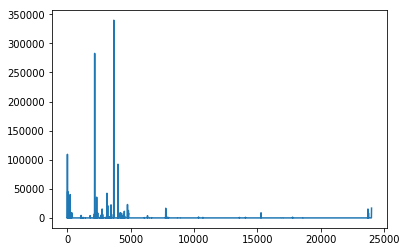

In [12]:
# Plot sample expression distribution
values = test[100]
times = numpy.arange(len(test[0])) * 10 
plt.plot(times, values)

## Extracting feature importance

In [13]:
# Top 10 most important features, ranked by random forest 
importances = rfmodel.feature_importances_
indices = numpy.argsort(importances)[::-1]
#for f in range(train.shape[1]):
for f in range(0,10):
    print("%d. feature %s (%f)" % (f + 1 , data.columns[indices[f]], importances[indices[f]]))


1. feature hsa_miR_205_5p (0.011021)
2. feature hsa_miR_135a_5p (0.010891)
3. feature hsa_miR_194_5p (0.010295)
4. feature hsa_miR_192_5p (0.010200)
5. feature hsa_miR_375 (0.009484)
6. feature hsa_miR_205_3p (0.009425)
7. feature hsa_miR_944 (0.008933)
8. feature hsa_miR_200c_5p (0.008926)
9. feature hsa_miR_122_5p (0.008564)
10. feature hsa_miR_194_3p (0.008348)


## Tuning the learning rate

The output `400epoch50learn` contains dictionaries for accuracy results at different learning rates, and accuracy results for different epochs. 

Learning rates were generated using `numpy.geomspace` for logarithmically spaced values. 

In [14]:
#### CAREFUL
#### You are about to load in new variables from the cluster 
#### To use for further visualization 
filename='db/400epoch50learn'
with open(filename, 'rb') as fp:
    learnloss = pickle.load(fp)
    histories = pickle.load(fp)

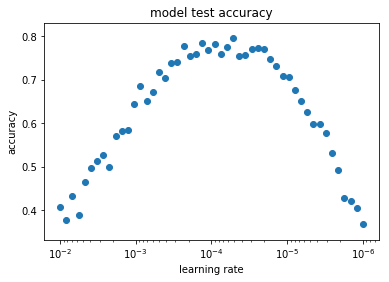

In [15]:
## First plot accuracy vs learning rate to decide on a good range 

def visualizeLearnLossRange(learnloss): 
    plt.title('model test accuracy')
    plt.xscale('log')
    plt.ylabel('accuracy')
    plt.xlabel('learning rate')
    plt.scatter(list(learnloss.keys()),list(learnloss.values()))
    plt.gca().invert_xaxis()
    #plt.axvspan(2.8e-04, 2e-05, color='yellow', alpha=0.5)
    plt.savefig("mirna/accuracy_learningrate_range.pdf")
    plt.show()

visualizeLearnLossRange(learnloss)


In [10]:
## Look at rates and decide lower/upper bound 
max_acc = max(learnloss.values())  # maximum value
max_lr = [k for k, v in learnloss.items() if v == max_acc] # getting all keys containing the `maximum`
print("Max test accuracy: ")
print(max_acc, max_lr)

# print(ll)
# print("Mean Accuracy: " + str(numpy.mean(histories[ll]['acc'])))
# print("Max Accuracy: " + str(max(histories[ll]['acc'])))
orderedkeys = []
for ll in learnloss:
    orderedkeys.append(ll)
orderedkeys = sorted(orderedkeys)

# get numbers for plotting
# good rates are above 0.77 when training 
counter = 0
goodrates = []
for ll in orderedkeys: 
#    if ll < 3e-04 and ll > 2.5e-05: 
    if learnloss[ll] > 0.77: 
        counter+=1
        goodrates.append(ll)
        print("Rate: " + str(ll) + "\tAccuracy: "+ str(learnloss[ll]))
print(counter)


filename='goodrates'
with open(filename, 'wb') as fp:
    pickle.dump(goodrates, fp)


Max test accuracy: 
(0.7946127946127947, [5.1794746792312125e-05])
Rate: 2.4420530945486548e-05	Accuracy: 0.7727272727272727
Rate: 5.1794746792312125e-05	Accuracy: 0.7946127946127947
Rate: 6.250551925273976e-05	Accuracy: 0.773989898989899
Rate: 9.102981779915228e-05	Accuracy: 0.7815656565656566
Rate: 0.00013257113655901095	Accuracy: 0.7849326599326599
Rate: 0.00023299518105153718	Accuracy: 0.7781986531986532
6


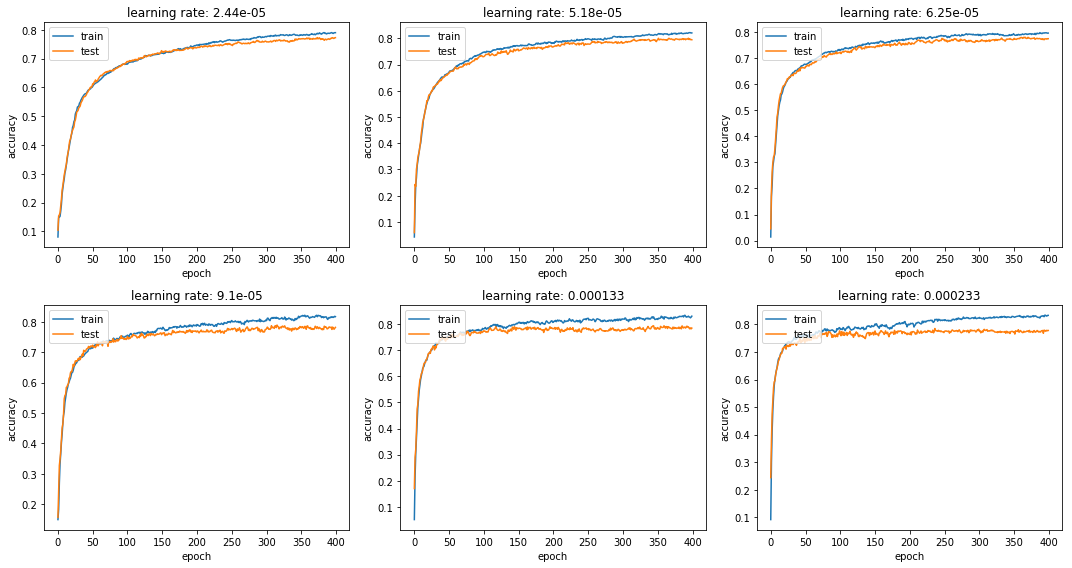

In [98]:
def visualizeEpochs(learnloss, histories):
    fig = plt.figure(figsize=(10,3))
    counter = 0
    nrRows = 2
    nrCols = 3
    for lr in goodrates: 
        # generate subplots 
        ax = fig.add_subplot(nrRows, nrCols, counter+1)
        ax.plot(histories[lr]['acc'])
        ax.plot(histories[lr]['val_acc'])
        plt.title('learning rate: ' + '{:.3g}'.format(lr))
        ax.set_ylabel('accuracy')
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='upper left')
        counter +=1
    fig.set_figheight(8)
    fig.set_figwidth(15)
    plt.tight_layout()
    plt.savefig("accuracy_epochs.pdf")
    plt.show()
            

visualizeEpochs(learnloss, histories)

In [32]:
# Learning rate: 0.01 to 0.000001
# encoded labels are one-hot encoded 
# Test labels are treated with ravel
learnloss = {} 
histories = {}
def learnLoss(learningRate, epochs, train, encoded_train, test, encoded_test, test_labels):
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, activation='sigmoid'))
    model.add(layers.Dense(128, activation='sigmoid'))
    model.add(layers.Dense(17, activation='softmax'))
    model.compile(optimizer=tf.train.RMSPropOptimizer(learningRate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    model.fit(train, encoded_train, validation_data=(test, encoded_test), epochs=epochs, batch_size=32)
    
    
    # test 
    pred_y = model.predict_classes(test)
    nnyhat = confusion_matrix(test_types, pred_y)
    accuracy = metrics.accuracy_score(test_labels, pred_y)
    print("Accuracy: ", accuracy)
    learnloss[learningRate] = accuracy 
    histories[learningRate] = model.history.history

In [ ]:
learningRates =  numpy.geomspace(0.01, 0.000001, num=50)
print(learningRates)
for lr in learningRates:
    learnLoss(lr, 500, train, encoded_train, test, encoded_test, r_test_types)


In [ ]:
### CAREFUL
### You are about to DUMP and replace the current saved variables

filename='500epoch50learn'
with open(filename, 'wb')as fp:
    pickle.dump(learnloss, fp)
    pickle.dump(histories, fp)
    
filename='500epoch50learn'
with open(filename, 'rb') as fp:
    learnloss = pickle.load(fp)
    histories = pickle.load(fp)


## Tuning the batch size
Batch sizes were chosen from 100 to 2000, and then narrowed down from 1 to 100 

In [81]:
filename='200epoch-10batch'
with open(filename, 'rb') as fp:
    batch_acc = pickle.load(fp)
    batch_hist = pickle.load(fp)

In [87]:
orderedkeys = []
for b in batch_acc:
    orderedkeys.append(b)
orderedkeys = sorted(orderedkeys)

counter = 0
goodrates = []
for b in orderedkeys: 
#     if learnloss[ll] > 0.77: 
#         counter+=1
#         goodrates.append(ll)
    print("Batch: " + str(b) + "\tAccuracy: "+ str(batch_acc[b]))
print(counter)

Batch: 1	Accuracy: 0.7373737373737373
Batch: 11	Accuracy: 0.7672558922558923
Batch: 21	Accuracy: 0.7243265993265994
Batch: 31	Accuracy: 0.742003367003367
Batch: 41	Accuracy: 0.7617845117845118
Batch: 51	Accuracy: 0.7441077441077442
Batch: 61	Accuracy: 0.7310606060606061
Batch: 71	Accuracy: 0.7184343434343434
Batch: 81	Accuracy: 0.7268518518518519
Batch: 91	Accuracy: 0.7264309764309764
Batch: 101	Accuracy: 0.7251683501683501
Batch: 111	Accuracy: 0.7344276094276094
Batch: 121	Accuracy: 0.7117003367003367
Batch: 131	Accuracy: 0.7293771043771043
Batch: 141	Accuracy: 0.7024410774410774
Batch: 151	Accuracy: 0.70496632996633
Batch: 161	Accuracy: 0.7175925925925926
Batch: 171	Accuracy: 0.7184343434343434
Batch: 181	Accuracy: 0.6746632996632996
Batch: 191	Accuracy: 0.6898148148148148
Batch: 201	Accuracy: 0.6712962962962963
Batch: 211	Accuracy: 0.6708754208754208
Batch: 221	Accuracy: 0.6944444444444444
Batch: 231	Accuracy: 0.6553030303030303
Batch: 241	Accuracy: 0.6632996632996633
Batch: 251	Acc

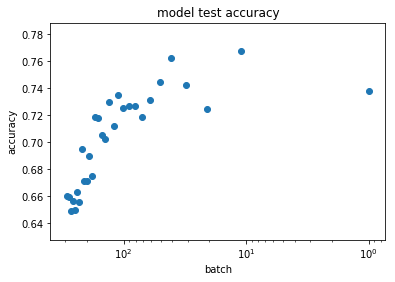

In [84]:
## First plot accuracy vs learning rate to decide on a good range 

def visualizeMetricAcc(dic): 
    plt.title('model test accuracy')
    plt.xscale('log')
    plt.ylabel('accuracy')
    plt.xlabel('batch')
    plt.scatter(list(dic.keys()),list(dic.values()))
    plt.gca().invert_xaxis()
#     plt.axvspan(2.8e-04, 2e-05, color='yellow', alpha=0.5)
#     plt.savefig("accuracy_learningrate_range.pdf")
    plt.show()

visualizeMetricAcc(batch_acc)


In [86]:
## Look at rates and decide lower/upper bound 
max_acc = max(batch_acc.values())  # maximum value
max_lr = [k for k, v in batch_acc.items() if v == max_acc] # getting all keys containing the `maximum`
print("Max test accuracy: ")
print(max_acc, max_lr)


Max test accuracy: 
(0.7672558922558923, [11])


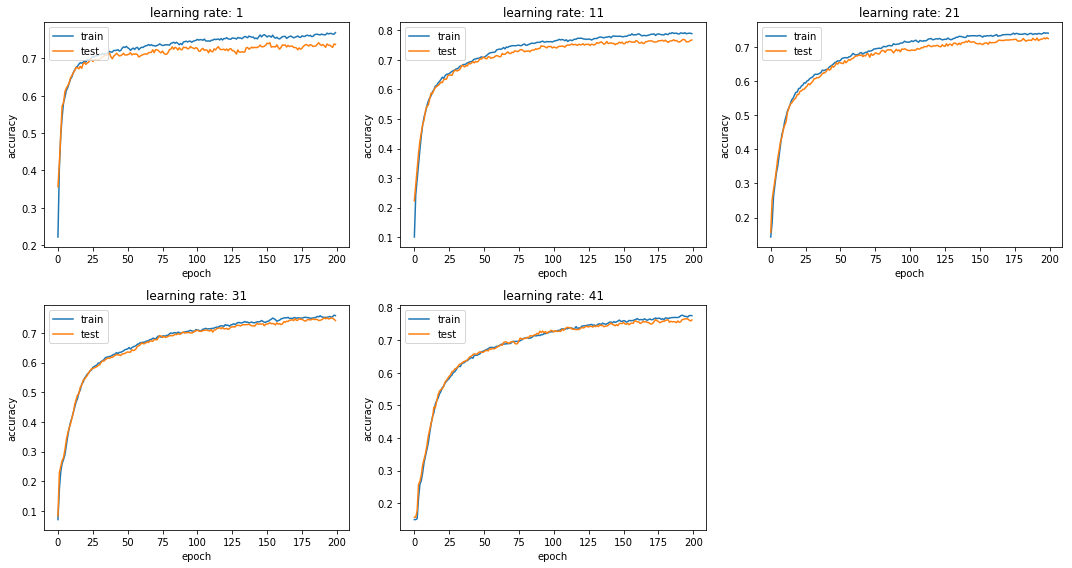

In [104]:
def visualizeEpochsGeneral(learnloss, histories):
    fig = plt.figure(figsize=(10,3))
    counter = 0
    nrRows = 2
    nrCols = 3
    for lr in learnloss: 
        if lr < 100 and lr < 50:
            ax = fig.add_subplot(nrRows, nrCols, counter+1)
            ax.plot(histories[lr]['acc'])
            ax.plot(histories[lr]['val_acc'])
            plt.title('learning rate: ' + '{:.3g}'.format(lr))
            ax.set_ylabel('accuracy')
            ax.set_xlabel('epoch')
            ax.legend(['train', 'test'], loc='upper left')
            counter +=1
    fig.set_figheight(8)
    fig.set_figwidth(15)
    plt.tight_layout()
    #plt.savefig("accuracy_epochs.pdf")
    plt.show()
            

visualizeEpochsGeneral(batch_acc, batch_hist)

#### Code beyond this point was for debugging purposes. 

In [31]:
model = tf.keras.Sequential()
print(train.shape)
#model.add(layers.InputLayer(input_tensor=train, input_shape=train.shape))
model.add(layers.Dense(128, activation='sigmoid', input_dim=2403))
#model.add(layers.Dense(128, activation='sigmoid'))
model.add(layers.Dense(128, activation='sigmoid'))
model.add(layers.Dense(17, activation='softmax'))
model.compile(optimizer=tf.train.RMSPropOptimizer(5.1794746792312125e-05),
          loss='categorical_crossentropy',
          metrics=['accuracy'])

(5574, 2403)


In [32]:
model.fit(train, encoded_train, validation_data=(test, encoded_test), epochs=200, batch_size=32)

Train on 5574 samples, validate on 2376 samples
Epoch 1/200
5574/5574 [==============================] - 2s 359us/step - loss: 3.0177 - acc: 0.0389 - val_loss: 2.8519 - val_acc: 0.0728
Epoch 2/200
5574/5574 [==============================] - 1s 186us/step - loss: 2.7467 - acc: 0.1157 - val_loss: 2.6778 - val_acc: 0.1570
Epoch 3/200
5574/5574 [==============================] - 1s 187us/step - loss: 2.6550 - acc: 0.1498 - val_loss: 2.6291 - val_acc: 0.1587
Epoch 4/200
5574/5574 [==============================] - 1s 186us/step - loss: 2.6131 - acc: 0.1554 - val_loss: 2.5918 - val_acc: 0.1717
Epoch 5/200
5574/5574 [==============================] - 1s 188us/step - loss: 2.5760 - acc: 0.1799 - val_loss: 2.5559 - val_acc: 0.2155
Epoch 6/200
5574/5574 [==============================] - 1s 219us/step - loss: 2.5379 - acc: 0.2318 - val_loss: 2.5175 - val_acc: 0.2576
Epoch 7/200
5574/5574 [==============================] - 1s 231us/step - loss: 2.4968 - acc: 0.2618 - val_loss: 2.4775 - val_acc: 

Epoch 60/200
5574/5574 [==============================] - 1s 171us/step - loss: 0.7606 - acc: 0.7949 - val_loss: 0.8083 - val_acc: 0.7765
Epoch 61/200
5574/5574 [==============================] - 1s 169us/step - loss: 0.7459 - acc: 0.7996 - val_loss: 0.7934 - val_acc: 0.7778
Epoch 62/200
5574/5574 [==============================] - 1s 170us/step - loss: 0.7309 - acc: 0.7998 - val_loss: 0.7786 - val_acc: 0.7854
Epoch 63/200
5574/5574 [==============================] - 1s 169us/step - loss: 0.7167 - acc: 0.8018 - val_loss: 0.7650 - val_acc: 0.7883
Epoch 64/200
5574/5574 [==============================] - 1s 167us/step - loss: 0.7030 - acc: 0.8082 - val_loss: 0.7512 - val_acc: 0.7891
Epoch 65/200
5574/5574 [==============================] - 1s 169us/step - loss: 0.6896 - acc: 0.8086 - val_loss: 0.7382 - val_acc: 0.7934
Epoch 66/200
5574/5574 [==============================] - 1s 169us/step - loss: 0.6767 - acc: 0.8131 - val_loss: 0.7260 - val_acc: 0.7929
Epoch 67/200
5574/5574 [==========

5574/5574 [==============================] - 1s 214us/step - loss: 0.1677 - acc: 0.9528 - val_loss: 0.2461 - val_acc: 0.9242
Epoch 179/200
5574/5574 [==============================] - 1s 189us/step - loss: 0.1664 - acc: 0.9532 - val_loss: 0.2448 - val_acc: 0.9247
Epoch 180/200
5574/5574 [==============================] - 1s 175us/step - loss: 0.1649 - acc: 0.9528 - val_loss: 0.2421 - val_acc: 0.9272
Epoch 181/200
5574/5574 [==============================] - 1s 173us/step - loss: 0.1635 - acc: 0.9535 - val_loss: 0.2430 - val_acc: 0.9251
Epoch 182/200
5574/5574 [==============================] - 1s 184us/step - loss: 0.1621 - acc: 0.9546 - val_loss: 0.2422 - val_acc: 0.9238
Epoch 183/200
5574/5574 [==============================] - 1s 197us/step - loss: 0.1608 - acc: 0.9537 - val_loss: 0.2395 - val_acc: 0.9263
Epoch 184/200
5574/5574 [==============================] - 1s 205us/step - loss: 0.1594 - acc: 0.9557 - val_loss: 0.2392 - val_acc: 0.9259
Epoch 185/200
5574/5574 [================

In [30]:
nn_pred = model.predict_classes(test)

nnyhat = confusion_matrix(test_types, nn_pred)
print(nnyhat)
print("Accuracy: ", metrics.accuracy_score(r_test_types, nn_pred))
# for i in range(len(r_test_labels)):
#     print("X=%s, Predicted=%s" % (r_test_labels[i], ynew[i]))

y_true = pd.Series(r_test_labels)
y_pred = pd.Series(nn_pred)

pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

[[139   0   1   0   0   0   0   0   0   0   0   0   0   0   4   0   0]
 [  0 123   0   0   1   7   1   0   0   0   0   0   0   0   0   0   0]
 [  0   4 369   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   2   0  10   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   2   0   0 145   5   0   0   0   0   0   0   2   0   0   0   0]
 [  0  24   0   0   6  33   1   0   0   0   0   0   2   0   0   0   0]
 [  0   3   0   0   0   5 144   0   0   0   0   0   3   1   1   0   0]
 [  0   0   0   0   0   0   0  30   0   0   0   0   0   0   0   0   0]
 [  0   0   2   0   0   0   0   0 176   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0 116   1   0   1   0   0   1   0]
 [  0   3   4   0   1   1   0   0   0   0 159   0   3   0   2   0   0]
 [  0   0   2   0   0   0   0   0   0   0   0 168   0   0   0   0   0]
 [  0   0   0   0   7   7   2   0   0   0   1   0 126   0   0   3   0]
 [  0   0   0   0   0   0   0   1   0   0   3   0   0 165   0   0   0]
 [  0 

Predicted,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,All
True,,,,,,,,,,,,,,,,,,
blca,0,123,0,0,1,7,1,0,0,0,0,0,0,0,0,0,0,132
brca,0,4,369,0,0,0,0,0,0,0,0,0,0,0,0,0,0,373
chol,0,2,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,12
coad,0,2,0,0,145,5,0,0,0,0,0,0,2,0,0,0,0,154
esca,0,24,0,0,6,33,1,0,0,0,0,0,2,0,0,0,0,66
hnsc,0,3,0,0,0,5,144,0,0,0,0,0,3,1,1,0,0,157
kich,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,30
kirc,0,0,2,0,0,0,0,0,176,0,0,0,0,0,0,0,0,178
lich,0,0,0,1,0,0,0,0,0,116,1,0,1,0,0,1,0,120


In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               307712    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 17)                2193      
Total params: 326,417
Trainable params: 326,417
Non-trainable params: 0
_________________________________________________________________


In [23]:

print(classification_report(test_types, nn_pred))

print(accuracy_score(test_types, nn_pred, normalize=True, sample_weight=None))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       144
           1       0.78      0.94      0.86       132
           2       0.96      1.00      0.98       373
           3       1.00      0.83      0.91        12
           4       0.90      0.94      0.92       154
           5       0.66      0.53      0.59        66
           6       0.96      0.95      0.96       157
           7       1.00      0.97      0.98        30
           8       0.98      0.99      0.99       178
           9       1.00      0.97      0.99       120
          10       0.97      0.93      0.95       173
          11       1.00      0.98      0.99       170
          12       0.89      0.87      0.88       146
          13       1.00      0.99      0.99       169
          14       0.97      0.96      0.96       179
          15       0.93      0.86      0.90        50
          16       0.99      0.98      0.99       123

   micro avg       0.95   

In [34]:

print(classification_report(test_types, nn_pred))

print(accuracy_score(test_types, nn_pred, normalize=True, sample_weight=None))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       144
           1       0.76      0.93      0.84       132
           2       0.97      0.99      0.98       373
           3       0.91      0.83      0.87        12
           4       0.91      0.94      0.92       154
           5       0.57      0.50      0.53        66
           6       0.97      0.92      0.94       157
           7       0.97      1.00      0.98        30
           8       0.99      0.99      0.99       178
           9       1.00      0.97      0.98       120
          10       0.96      0.92      0.94       173
          11       1.00      0.99      0.99       170
          12       0.87      0.86      0.87       146
          13       0.99      0.98      0.99       169
          14       0.96      0.96      0.96       179
          15       0.89      0.84      0.87        50
          16       1.00      0.99      1.00       123

   micro avg       0.94   

## Cross-validation (in-progress)

In [59]:
## Try cross validation 

# Load libraries
import numpy as np
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

In [63]:
# Create function returning a compiled network
def create_network():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, activation='sigmoid'))
    model.add(layers.Dense(128, activation='sigmoid'))
    model.add(layers.Dense(17, activation='softmax'))
    model.compile(optimizer=tf.train.RMSPropOptimizer(5.1794746792312125e-05),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    # Return compiled network
    return model

In [67]:
# Wrap Keras model so it can be used by scikit-learn
neural_network = KerasClassifier(build_fn=create_network, 
                                 epochs=100, 
                                 batch_size=32, 
                                 verbose=0)

In [68]:
# Evaluate neural network using three-fold cross-validation
cross_val_score(neural_network, train, encoded_train, cv=3)

array([0.65285253, 0.66469322, 0.66953714])